# Optimization 

## Network Flow
Optimize how to send goods from a source node to a destination node through a network while minimizing transportation costs. Each edge in the network has a capacity limit and a cost per unit flow. The goal is to determine the optimal flow through the network that meets demand at the destination without exceeding capacities.

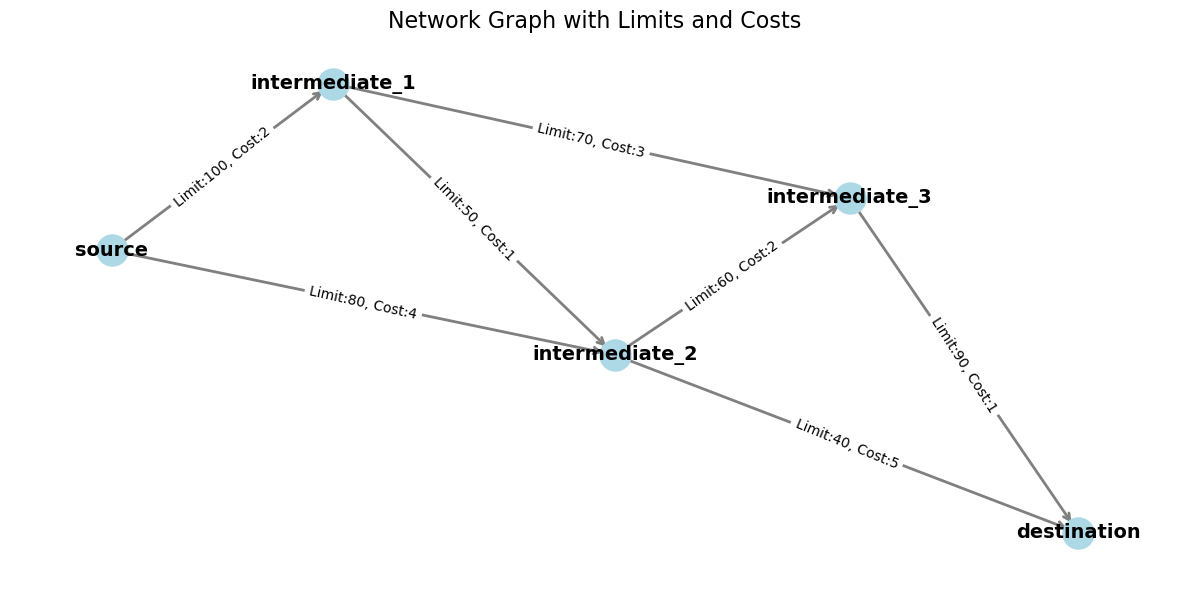

In [87]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx

nodes = ['source', 'intermediate_1', 'intermediate_2', 'intermediate_3', 'destination']
edges = [
    ('source', 'intermediate_1'),
    ('source', 'intermediate_2'),
    ('intermediate_1', 'intermediate_2'),
    ('intermediate_1', 'intermediate_3'),
    ('intermediate_2', 'intermediate_3'),
    ('intermediate_2', 'destination'),
    ('intermediate_3', 'destination'),
]
limits = {
    ('source', 'intermediate_1'): 100,
    ('source', 'intermediate_2'): 80,
    ('intermediate_1', 'intermediate_2'): 50,
    ('intermediate_1', 'intermediate_3'): 70,
    ('intermediate_2', 'intermediate_3'): 60,
    ('intermediate_2', 'destination'): 40,
    ('intermediate_3', 'destination'): 90,
}
costs = {
    ('source', 'intermediate_1'): 2,
    ('source', 'intermediate_2'): 4,
    ('intermediate_1', 'intermediate_2'): 1,
    ('intermediate_1', 'intermediate_3'): 3,
    ('intermediate_2', 'intermediate_3'): 2,
    ('intermediate_2', 'destination'): 5,
    ('intermediate_3', 'destination'): 1,
}

# Demand at each node (positive for demand, negative for supply)
demand = {
    'source': -100,  # Supply of 100 units
    'intermediate_1': 0,
    'intermediate_2': 0,
    'intermediate_3': 0,
    'destination': 100,   # Demand of 100 units
}

plt.figure(figsize=(12, 6))
G = nx.DiGraph()
G.add_nodes_from(nodes)

for edge in edges:
    G.add_edge(edge[0], edge[1])

pos = nx.spring_layout(G, seed=19)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, edge_color='gray', width=2)
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')
edge_labels = {edge: f"Limit:{limits[edge]}, Cost:{costs[edge]}" for edge in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)
plt.axis('off')
plt.title("Network Graph with Limits and Costs", fontsize=16)
plt.tight_layout()
plt.show()

In [88]:
# Create variables for flows on each edge
flow = {}
for edge in edges:
    flow[edge] = cp.Variable(nonneg=True)

# Objective: Minimize total transportation cost
total_cost = cp.sum([
    costs[edge] * flow[edge] for edge in edges
])
objective = cp.Minimize(total_cost)

constraints = []
for edge in edges:
    constraints.append(flow[edge] <= limits[edge])

# Flow conservation at each node
for node in nodes:
    inflow = cp.sum([
        flow[(i, j)] for (i, j) in edges if j == node
    ])
    outflow = cp.sum([
        flow[(i, j)] for (i, j) in edges if i == node
    ])
    # Net flow equals demand
    constraints.append(inflow - outflow == demand.get(node, 0))

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

print(f"Minimum total transportation cost: ${problem.value:.2f}\n")
print("Optimal flow on each edge:")
for edge in edges:
    flow_value = flow[edge].value if flow[edge].value is not None else 0
    print(f"Flow from {edge[0]} to {edge[1]}: {flow_value:.2f} units")

Minimum total transportation cost: $620.00

Optimal flow on each edge:
Flow from source to intermediate_1: 100.00 units
Flow from source to intermediate_2: 0.00 units
Flow from intermediate_1 to intermediate_2: 41.43 units
Flow from intermediate_1 to intermediate_3: 58.57 units
Flow from intermediate_2 to intermediate_3: 31.43 units
Flow from intermediate_2 to destination: 10.00 units
Flow from intermediate_3 to destination: 90.00 units


## Portfolio Optimization
Portfolio optimization has two competing objectives: high return and low risk.

**Variables**:
* $\mu$: Expected returns
* $N$: Number of assets
* $w_i$: Fraction of money to invest in asset $i$
* $\Sigma$: Covariance matrix which quantifies how different assets in a portfolio move relative to each other.
* $\gamma>0$: Risk aversion parameter

**Objective**: maximize $\mu^T w - \gamma w^T\Sigma w$  (risk-adjusted return)

**Constraints**:
* $\sum_{i=0}^N w_i = 1$
* $w_i >= 0$

In [84]:
expected_returns = np.array([0.08, 0.12, 0.15, 0.06])  # [Bonds, VTI, International, Small-Cap]
weights = cp.Variable(len(expected_returns))
risk_aversion = 0.0

covariance_matrix = np.array([
    [1.0, 0.3, 0.2, 0.1],
    [0.3, 1.0, 0.4, 0.5],
    [0.2, 0.4, 1.0, 0.6],
    [0.1, 0.5, 0.6, 1.0]
])

constraints = [cp.sum(weights) == 1, weights >= 0]
portfolio_variance = cp.quad_form(weights, covariance_matrix)
objective = cp.Maximize(expected_returns.T @ weights - portfolio_variance * risk_aversion)
problem = cp.Problem(objective, constraints)
problem.solve()
optimal_weights = weights.value
optimal_weights

array([-2.14111410e-28, -2.14377958e-28,  1.00000000e+00, -2.13978135e-28])

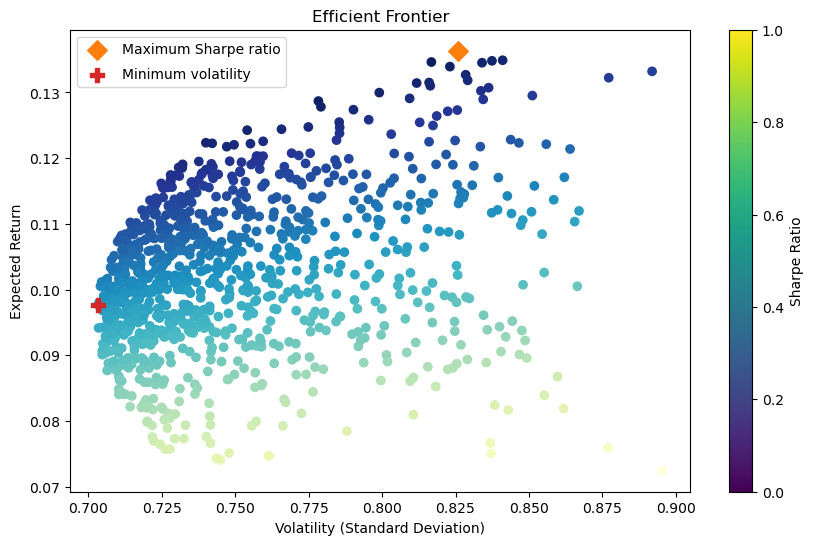

In [86]:
def calculate_portfolio_performance(weights, expected_returns, covariance_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_return, portfolio_risk

risk_free_rate = 0.03
num_portfolios = 1000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(expected_returns))
    weights /= np.sum(weights)
    portfolio_return, portfolio_risk = calculate_portfolio_performance(weights, expected_returns, covariance_matrix)
    results[0,i] = portfolio_risk
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_risk  # Sharpe ratio
    weights_record.append(weights)

max_sharpe_idx = np.argmax(results[2])
sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
max_sharpe_allocation = pd.DataFrame(weights_record[max_sharpe_idx], index=['Bonds', 'VTI', 'International', 'Small-Cap'], columns=['allocation'])

min_vol_idx = np.argmin(results[0])
sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
min_vol_allocation = pd.DataFrame(weights_record[min_vol_idx], index=['Bonds', 'VTI', 'International', 'Small-Cap'], columns=['allocation'])

plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o')
plt.scatter(sdp, rp, marker='D', color='tab:orange', s=100, label='Maximum Sharpe ratio')
plt.scatter(sdp_min, rp_min, marker='P', color='tab:red', s=100, label='Minimum volatility')

plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.legend(labelspacing=0.8)
plt.show()

## Workforce Scheduling
Goal: schedule employees to cover shifts over a week. Minimize labor costs while ensuring that staffing requirements.

Assumptions:
- 7 days a week with two 8 hour shifts per day: Day and Night.
- Number of employees needed vary by shift.
- There are 4 employees available, each with different hourly wages.
- Employees can work any shift but cannot exceed 40 hours per week.

In [2]:
employees = ['Alice', 'Bob', 'Charlie', 'Diana']
wages = np.array([20, 17, 22, 19])
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
shifts = ['Day', 'Night']
staff_req = np.array([
    [1, 1],  # Monday
    [1, 1],  # Tuesday
    [1, 1],  # Wednesday
    [1, 1],  # Thursday
    [1, 1],  # Friday
    [1, 1],  # Saturday
    [1, 1],  # Sunday
])

shift_length = 8
max_weekly_hours = 40
num_employees = len(employees)
num_days = len(days)
num_shifts = len(shifts)

# Decision variables: x[e, d, s] = 1 if employee e works on day d shift s, else 0
x = {}
for e in range(num_employees):
    for d in range(num_days):
        for s in range(num_shifts):
            x[e, d, s] = cp.Variable(boolean=True)

# Objective: Minimize total labor cost
total_cost = cp.sum([
    wages[e] * shift_length * x[e, d, s]
    for e in range(num_employees)
    for d in range(num_days)
    for s in range(num_shifts)
])
objective = cp.Minimize(total_cost)
constraints = []

# Each shift must be fully staffed
for d in range(num_days):
    for s in range(num_shifts):
        constraints.append(
            cp.sum([x[e, d, s] for e in range(num_employees)]) >= staff_req[d, s]
        )

# No employee works more than max_weekly_hours per week
for e in range(num_employees):
    constraints.append(
        cp.sum([
            shift_length * x[e, d, s]
            for d in range(num_days)
            for s in range(num_shifts)
        ]) <= max_weekly_hours
    )

# An employee cannot work more than one shift per day
for e in range(num_employees):
    for d in range(num_days):
        constraints.append(cp.sum([x[e, d, s] for s in range(num_shifts)]) <= 1)

problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS_BB, verbose=False)

if problem.status not in ["infeasible", "unbounded"]:
    print(f"Optimal total labor cost: ${problem.value:.2f}\n")

    # Corrected the way we access variable values
    for e, employee in enumerate(employees):
        total_hours = shift_length * sum([
            x[e, d, s].value
            for d in range(num_days)
            for s in range(num_shifts)
            if x[e, d, s].value is not None
        ])
        print(f"{employee}: \n  Total Hours = {total_hours:.1f} hrs")
        for d, day in enumerate(days):
            for s, shift in enumerate(shifts):
                if x[e, d, s].value is not None and x[e, d, s].value > 0.5:
                    print(f"  {day} {shift} Shift: {shift_length} hrs")
        print()
else:
    print(f"Problem Status: {problem.status}")
    print("The problem is infeasible; adjust the constraints or data.")

NameError: name 'np' is not defined

## References
- [CVXPY Examples](https://www.cvxpy.org/examples/index.html)
- [Jon Lee: A First Course in Linear Optimization](https://github.com/jon77lee/JLee_LinearOptimizationBook)